<a href="https://colab.research.google.com/github/KoMurase/movie_research_2/blob/master/baseline_lgb_2016_19_title_review_KFold_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r '/content/drive/MyDrive/Movies/data/mojo_japan/' '/content/'

!cp -r '/content/drive/MyDrive/Movies/data/metadata_filmarks/' '/content/'

In [3]:
!pip install japanize_matplotlib
import pandas as pd
import codecs 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import japanize_matplotlib

import warnings

import os
from tqdm import tqdm
import gc

     |████████████████████████████████| 4.1MB 11.3MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-cp36-none-any.whl size=4120276 sha256=d65c707a4aea8e25d20153e9ace81a0dc6c2be8558728a6a0629d704034a64f8
  Stored in directory: /root/.cache/pip/wheels/b7/d9/a2/f907d50b32a2d2008ce5d691d30fb6569c2c93eefcfde55202
Successfully built japanize-matplotlib


In [4]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split

#評価
from sklearn.metrics import r2_score
#r2_score(y_true, y_pred)

In [5]:
path = '/content/drive/MyDrive/Movies/preprocessed/'

In [6]:
def read_data(path, encode_type):
  
  with codecs.open(path, "r", encode_type, "ignore") as file:
    output = pd.read_csv(file, delimiter=",")
      
  return output

In [7]:
train = read_data(path+'train_2016-2018_title.csv', encode_type='utf-8')
test = read_data(path+'test_2019_title.csv', encode_type='utf-8')

train = train.loc[train['Title'].drop_duplicates(keep='first').index]

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (5628) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


#reviewデータの結合

In [8]:
review = pd.read_csv('/content/drive/MyDrive/Movies/preprocessed/keiyousi_2016-2019.csv')

In [9]:
review_ = review.drop_duplicates()

In [10]:
train.shape, review_.shape

((514, 9063), (683, 489))

In [11]:
review_

,Title,Title(ja),title_url,keiyousi_contains_良い,keiyousi_contains_無い,keiyousi_contains_面白い,keiyousi_contains_凄い,keiyousi_contains_可愛い,keiyousi_contains_欲しい,keiyousi_contains_多い,keiyousi_contains_強い,keiyousi_contains_悪い,keiyousi_contains_楽しい,keiyousi_contains_素晴らしい,keiyousi_contains_怖い,keiyousi_contains_旨い,keiyousi_contains_美しい,keiyousi_contains_深い,keiyousi_contains_高い,keiyousi_contains_長い,keiyousi_contains_難しい,keiyousi_contains_優しい,keiyousi_contains_嬉しい,keiyousi_contains_辛い,keiyousi_contains_少ない,keiyousi_contains_悲しい,keiyousi_contains_早い,keiyousi_contains_切ない,keiyousi_contains_大きい,keiyousi_contains_新しい,keiyousi_contains_熱い,keiyousi_contains_若い,keiyousi_contains_久しい,keiyousi_contains_懐かしい,keiyousi_contains_酷い,keiyousi_contains_重い,keiyousi_contains_薄い,keiyousi_contains_弱い,keiyousi_contains_仕方無い,keiyousi_contains_小さい,...,keiyousi_contains_空々しい,keiyousi_contains_睦まじい,keiyousi_contains_細長い,keiyousi_contains_苦々しい,keiyousi_contains_捗々しい,keiyousi_contains_口惜しい,keiyousi_contains_そそっかしい,keiyousi_contains_姦しい,keiyousi_contains_まだるっこい,keiyousi_contains_名残惜しい,keiyousi_contains_甘辛い,keiyousi_contains_か黒い,keiyousi_contains_弛い,keiyousi_contains_恐れ多い,keiyousi_contains_気強い,keiyousi_contains_嘆かわしい,keiyousi_contains_肌寒い,keiyousi_contains_悪賢い,keiyousi_contains_人臭い,keiyousi_contains_えらしい,keiyousi_contains_妬ましい,keiyousi_contains_木暗い,keiyousi_contains_人悪い,keiyousi_contains_か細い,keiyousi_contains_しおらしい,keiyousi_contains_派手派手しい,keiyousi_contains_きな臭い,keiyousi_contains_はしこい,keiyousi_contains_せせこましい,keiyousi_contains_きしょい,keiyousi_contains_馴れ馴れしい,keiyousi_contains_青黒い,keiyousi_contains_疑り深い,keiyousi_contains_侘しい,keiyousi_contains_刺々しい,keiyousi_contains_雪深い,keiyousi_contains_疚しい,keiyousi_contains_いみじい,keiyousi_contains_脂っこい,keiyousi_contains_美々しい
0,Detective Conan: Zero the Enforcer,TRi [̎sl,https://filmarks.com/movies/77412,0.440860,0.365591,0.247312,0.161290,0.021505,0.064516,0.032258,0.010753,0.032258,0.021505,0.010753,0.000000,0.010753,0.000000,0.000000,0.021505,0.010753,0.129032,0.000000,0.053763,0.010753,0.010753,0.000000,0.000000,0.000000,0.043011,0.010753,0.021505,0.010753,0.032258,0.000000,0.010753,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Code Blue the Movie,ŃR[hEu[ -hN^[wً}~-,https://filmarks.com/movies/76162,0.479167,0.281250,0.083333,0.052083,0.031250,0.052083,0.020833,0.041667,0.020833,0.041667,0.041667,0.010417,0.020833,0.020833,0.062500,0.010417,0.010417,0.020833,0.010417,0.010417,0.010417,0.010417,0.010417,0.010417,0.010417,0.020833,0.010417,0.010417,0.020833,0.000000,0.010417,0.010417,0.010417,0.020833,0.010417,0.000000,0.010417,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Jurassic World: Fallen Kingdom,WVbNE[h^̉,https://filmarks.com/movies/65519,0.326316,0.273684,0.136842,0.094737,0.147368,0.073684,0.031579,0.031579,0.052632,0.021053,0.021053,0.031579,0.000000,0.010526,0.052632,0.021053,0.000000,0.000000,0.000000,0.031579,0.042105,0.021053,0.031579,0.021053,0.010526,0.000000,0.031579,0.000000,0.000000,0.010526,0.000000,0.010526,0.000000,0.010526,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bohemian Rhapsody,{w~AEv\fB,https://filmarks.com/movies/73709,0.412371,0.329897,0.113402,0.154639,0.010309,0.030928,0.041237,0.030928,0.020619,0.030928,0.134021,0.000000,0.030928,0.010309,0.010309,0.010309,0.010309,0.010309,0.000000,0.030928,0.000000,0.000000,0.010309,0.020619,0.020619,0.010309,0.000000,0.010309,0.010309,0.010309,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [12]:
train.loc[train['Title'].duplicated(), ['Title','Gross', 'Total Gross']]

,Title,Gross,Total Gross


In [13]:
train.loc[train['Title']=='Bohemian Rhapsody', ['Title','Gross', 'Total Gross']]

,Title,Gross,Total Gross
0,Bohemian Rhapsody,51803285,115693295


In [14]:
review_ = review_.drop(['Title(ja)','title_url'], axis=1)

In [15]:
train = train.merge(review_, how='left', on='Title')
test = test.merge(review_, how='left', on='Title')

#前処理必要なカラム

> Theaters,Opening_Day,Country


> 今回，前処理されていないカラムname, Distributors

# 標準化が必要なカラム

> 'レビュー数', '平均スコア', 'Gross', 'Total Gross',    'Theaters'

In [16]:
train[train['Theaters']=='-'].__len__()

212

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


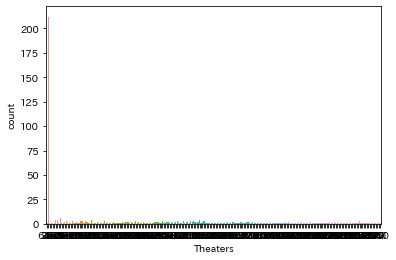

In [17]:
sns.countplot(train['Theaters'])

In [18]:
train['Theaters'].unique()

array(['645', '-', '365', '362', '468', '396', '366', '35', '746', '9',
       '62', '773', '375', '301', '568', '585', '371', '308', '709',
       '353', '322', '457', '775', '329', '360', '634', '332', '313', '1',
       '676', '291', '785', '347', '444', '682', '574', '970', '5', '128',
       '8', '596', '299', '156', '341', '314', '455', '745', '431', '705',
       '300', '275', '636', '342', '312', '4', '296', '331', '285', '696',
       '728', '6', '326', '252', '765', '406', '306', '198', '685', '756',
       '401', '302', '251', '148', '69', '59', '155', '273', '394', '52',
       '65', '196', '40', '150', '56', '246', '464', '180', '86', '120',
       '161', '33', '188', '34', '7', '210', '27', '101', '12', '50',
       '15', '16', '99', '25', '10', '483', '2', '22', '461', '640',
       '789', '673', '323', '417', '463', '260', '337', '193', '432',
       '249', '127', '231', '207', '336', '425', '194', '182', '235',
       '199', '113', '359', '145', '45', '28', '75', '226'

In [19]:
def preprocess_Theaters(input_df:pd.DataFrame)->pd.DataFrame:
  output_df = input_df.copy()
  plt.figure(figsize=(25,10))
  sns.countplot(input_df.loc[input_df['Theaters']!='-', 'Theaters'].astype(int).sort_values())
  plt.xticks(rotation=90)
  plt.show()
  print('- of number : {}'.format(input_df[input_df['Theaters']=='-'].__len__()))
  mean_ = input_df.loc[input_df['Theaters']!='-','Theaters'].astype(int).mean()

  print(f'mean of Theaters:{int(mean_)}')
  output_df['Theaters'] = output_df['Theaters'].replace('-', mean_).astype(int)

  return output_df

def lable_encoding(input_df:pd.DataFrame, cat_cols:list)->pd.DataFrame:
  output_df = input_df.copy()
  # カテゴリ変数は出現順にLabelEncoding
  for c in cat_cols:
    _dict = {j:i for i,j in enumerate(input_df[c].unique())}
    output_df[c] = input_df[c].map(_dict)
    
  return output_df

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


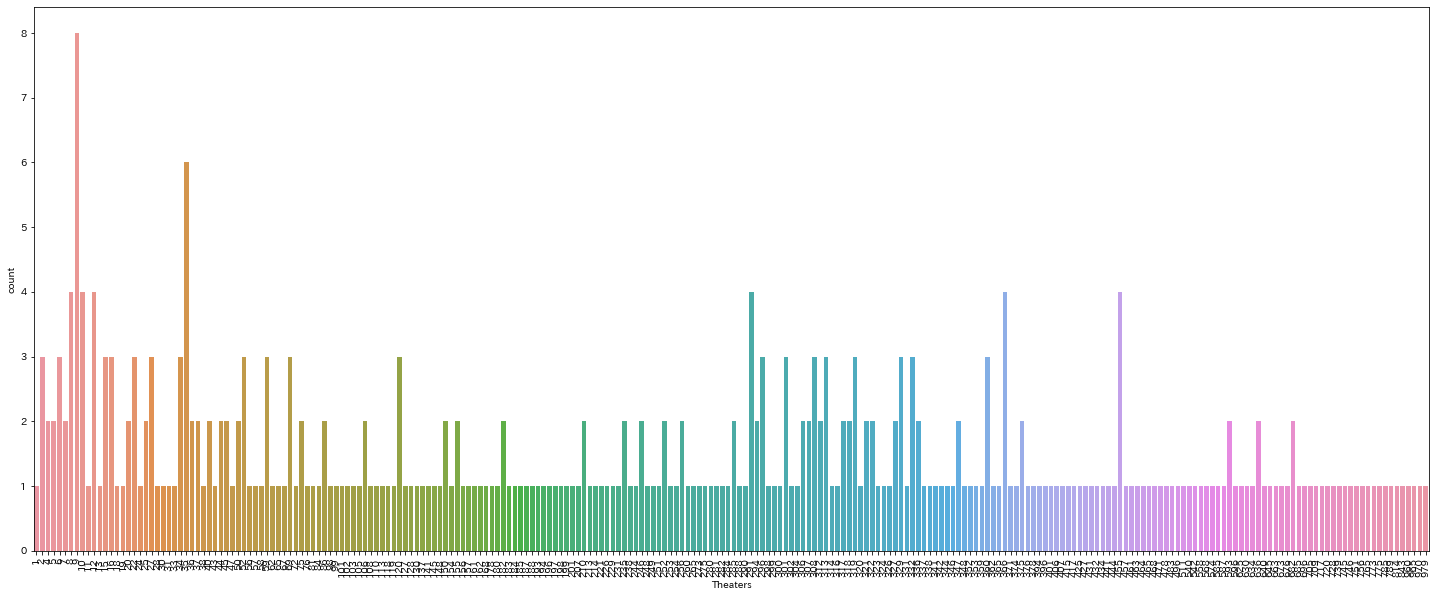

- of number : 338
mean of Theaters:263


In [20]:
data = pd.concat([train, test], axis=0).reset_index(drop=True)
data = preprocess_Theaters(data)

In [21]:
cols=['Country', 'Opening_Day']
data = lable_encoding(data, cols)

In [22]:
train = data[0:len(train)]
test = data[len(train):]

train.shape, test.shape

((519, 9549), (167, 9549))

In [23]:
train['Theaters'].describe()

count    519.000000
mean     270.957611
std      170.682284
min        1.000000
25%      213.500000
50%      263.000000
75%      306.000000
max      979.000000
Name: Theaters, dtype: float64

In [24]:
#アルゴリズムの方で分岐しているから必要ないかもしれない特徴量

def make_describe_col(input_df:pd.DataFrame, col:str):
  output_df = input_df.copy() 
  p_25 = output_df[col].describe()['25%']
  p_50 = output_df[col].describe()['50%']
  p_75 = output_df[col].describe()['75%']

  # 25%未満
  output_df[f'{col}_[x<25%]'] = output_df[col].apply(
      lambda x: 1 if x<p_25 else 0 
  )
  # 25%以上 50%未満
  output_df[f'{col}_[25<=x<50%]'] = output_df[col].apply(
      lambda x: 1 if x>=p_25 and x<p_50 else 0 
  )
  # 50%以上 75%未満
  output_df[f'{col}_[50<=x<75%]'] = output_df[col].apply(
      lambda x: 1 if x>=p_50 and x<p_75 else 0 
  )
  # 75%以上
  output_df[f'{col}_[75%<x]'] = output_df[col].apply(
      lambda x: 1 if x>=p_75 else 0 
  )

  return output_df

In [25]:
train = make_describe_col(train, 'Theaters')
train = make_describe_col(train, 'Time')

test = make_describe_col(test, 'Theaters')
test = make_describe_col(test, 'Time')

In [26]:
from sklearn import preprocessing

def normalization(df:pd.DataFrame, cols:list):
  output_df = df.copy()

  ss = preprocessing.StandardScaler()
  output_df[cols]= ss.fit_transform(output_df[cols])
  output_df[cols].add_suffix('_ss')

  return output_df 

In [27]:
""" use_columns = [
        'レビュー数',
        '平均スコア', 
        'Gross', 
        'Total Gross',
        'Theaters' ]

train = normalization(train, use_columns)
test = normalization(test, use_columns)"""

" use_columns = [\n        'レビュー数',\n        '平均スコア', \n        'Gross', \n        'Total Gross',\n        'Theaters' ]\n\ntrain = normalization(train, use_columns)\ntest = normalization(test, use_columns)"

# Training and Predicting 

##Making Folds

##Kfold

In [28]:
def create_folds(df, NUM_SPLITS, target):
    df = df.copy()
    df["kfold"] = -1 
    #fracで抽出する行の割合1は100%
    df = df.sample(frac=1).reset_index(drop=True)
    y = df[target].values   
    tkf = KFold(n_splits=NUM_SPLITS)
    for f, (t_, v_) in enumerate(tkf.split(X=df, y=y)):
        df.loc[v_,'kfold'] = f ###locより高速
    return df

# Custom Metric

In [29]:
from sklearn.metrics import mean_squared_log_error

def RMSLE(preds, data):
  y_true = data.get_label()
  score = np.sqrt(mean_squared_log_error(y_true, preds))
  return "RMSLE", score, True

from sklearn.metrics import mean_squared_error

def RMSE(preds, data):
  y_true = data.get_label() 
  score = np.sqrt(mean_squared_error(y_true, preds))

  return "RMSE", score, True

def metrics(preds, data):
    return [
        #accuracy(preds, data),
        #precision(preds, data),
        #recall(preds, data),
        #f1score_macro(preds, data),
        #RMSLE(preds, data),
        RMSE(preds, data)
    ]

In [30]:
from sklearn.metrics import r2_score

def trainer(train_df:pd.DataFrame, test_df:pd.DataFrame, target:str, fold:int, params:dict=None):
    df = train_df.copy()
    test = test_df.copy() 

    train_df = df[df.kfold != fold].reset_index(drop=True)
    valid_df = df[df.kfold == fold].reset_index(drop=True)

    del df 

    train_X = train_df.drop([target, 'kfold'], axis=1)
    #train_y = train_df[target]
    train_y = np.log1p(train_df[target])

    del train_df

    valid_X = valid_df.drop([target, 'kfold'], axis=1)
    #valid_y = valid_df[target]
    valid_y = np.log1p(valid_df[target])

    del valid_df


    dtrain = lgb.Dataset(train_X, train_y)
    dvalid = lgb.Dataset(valid_X, valid_y)

  
    if params is None:
        params = {}
  
    FIT_PARAMS_LGB = {
        "num_boost_round": 10000, 
        "early_stopping_rounds": 100, 
        "verbose_eval":100}

    evals_result = {}
    model = lgb.train(
      params, dtrain, **FIT_PARAMS_LGB,
      valid_names=['train', 'valid'], 
      valid_sets=[dtrain, dvalid],

      evals_result=evals_result,
      #feval=metrics
        )
  
    valid_pred = model.predict(valid_X,
                          num_iteration=model.best_iteration)
  
    test_pred = model.predict(test , axis=1,
                              num_iteration=model.best_iteration)
    
    #test['predict'] = np.stack(pred).mean(axis=0)

    
    RMSE = mean_squared_error(valid_y, valid_pred)**0.5
    print('Fold {} : RMSE {}'.format(fold, RMSE))
    
    R2 = r2_score(valid_y, valid_pred)
    print('Fold {} : R2 {}'.format(fold, R2))

    #model.save_model('/content/drive/MyDrive/SIGNATE_intern/model/lgb_fold{}.txt'.format(fold),
    #                 num_iteration=model.best_iteration)

    #model = lgb.Booster(model_file='*****.txt') で読み込める
    gc.collect()

    return valid_pred, test_pred, RMSE, evals_result, model

In [31]:
def create_folds(df:pd.DataFrame, target:str, NUM_SPLITS:int ):
    RANDOM_SEED=1
    df = df.copy()
    df["kfold"] = -1 
    #fracで抽出する行の割合1は100%
    df = df.sample(frac=1).reset_index(drop=True)
    y = df[target].values 
    kf = KFold(n_splits=NUM_SPLITS, random_state=RANDOM_SEED)
    for f, (t_, v_) in enumerate(kf.split(X=df)):
        df.loc[v_,'kfold'] = f 
    return df

#目的変数と説明変数の設定




In [32]:
#レビュー，平均スコアを含める場合
#drop_cols=['Title','Title(ja)','directors','writers','casts']

#----------------------------------------------------------------
#レビュー，平均スコアを含めない場合
drop_cols=['Title','Title(ja)','directors','writers','casts','レビュー数','平均スコア']

In [33]:
#train['Gross_log1p'] = train['Gross'].values
#train['Total Gross_log1p'] = train['Total Gross'].values

#y2 = np.log1p(y2)
#y = np.log1p(y)
#train = train.drop(drop_cols, axis=1)
#test = test.drop(drop_cols, axis=1)

In [34]:
#Total Grossを予測する場合
train_features = train.drop(drop_cols+['Gross'], axis=1) #'レビュー数','平均スコア'], axis=1)
test_features = test.drop(drop_cols+['Gross'], axis=1)     #'レビュー数','平均スコア'], axis=1)

#Grossを予測する場合
#train_features = train.drop(drop_cols+['Total Gross'], axis=1)#'レビュー数','平均スコア'], axis=1)
#test_features = test.drop(drop_cols+['Total Gross'], axis=1)  #'レビュー数','平均スコア'], axis=1)

In [35]:
#交差検証のための番号を振る

NUM_SPLITS = 3
target_col='Total Gross'
train_features = create_folds(train_features, target_col, NUM_SPLITS)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


#パラメータの設定

In [51]:
# 回帰分析にして学習させる
params = {
    'objective': 'regression',    'metric':'rmse', #'metric':'None', 
    'learning_rate': 0.005,    'max_depth': -1,
    'num_leaves': 30,    'max_bin': 31,
    'colsample_bytree': 0.8,    'subsample': 0.8,
    'nthread': -1,    'bagging_freq': 1,
    'verbose': -1,    'seed': 1,
    }

In [52]:
def run(seed_list:list):
    models = []
    scores = []
    eval_results = []
    oof = pd.DataFrame({'result':np.zeros(len(test))} )
    for seed in seed_list:
        print('SEED'+'★'*seed)
        scores = []
        #test_preds = []
        valid_preds = []
        
        params['num_leaves']+=seed
        params['max_bin']+=seed
        params['seed'] = seed

        for fold in range(NUM_SPLITS):
            print(f"fold {fold}", "-"*70)
            valid_pred, test_pred, score, evals_result, model = trainer(
                                                              train_features, test_features, target_col, fold, params)
            valid_preds.append(valid_pred)
            oof[f'result_{seed}_{fold}'] = test_pred
            #test_preds.append(test_pred)
            scores.append(score) 
            models.append(model)

            evals_result['seed']=seed
            evals_result['fold']=fold
            eval_results.append(evals_result)
    
    return oof, scores, models, eval_results

In [53]:
seed_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

oof, scores, models, eval_results = run(seed_list)

SEED★
fold 0 ----------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.3233	valid's rmse: 1.29997
[200]	train's rmse: 1.12044	valid's rmse: 1.20558
[300]	train's rmse: 0.98578	valid's rmse: 1.16786
[400]	train's rmse: 0.885517	valid's rmse: 1.14873
[500]	train's rmse: 0.803107	valid's rmse: 1.14064
[600]	train's rmse: 0.732312	valid's rmse: 1.13535
[700]	train's rmse: 0.674881	valid's rmse: 1.13396
Early stopping, best iteration is:
[641]	train's rmse: 0.70777	valid's rmse: 1.13368
Fold 0 : RMSE 1.1336776390726548
Fold 0 : R2 0.45198506999407695
fold 1 ----------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.29164	valid's rmse: 1.41145
[200]	train's rmse: 1.09281	valid's rmse: 1.2694
[300]	train's rmse: 0.952844	valid's rmse: 1.19733
[400]	train's rmse: 0.847704	valid's rmse: 1.15594
[500]	tr

In [54]:
"""scores = []
test_preds = []
valid_preds = []
models = []
eval_results = []
for fold in range(NUM_SPLITS):
    print(f"fold {fold}", "-"*70)
    valid_pred, test_pred, score, evals_result, model = trainer(
        train_features, test_features, target_col, fold, params)
    
    valid_preds.append(valid_pred)
    test_preds.append(test_pred)
    scores.append(score) 
    models.append(model)

    eval_results.append(evals_result)
"""

'scores = []\ntest_preds = []\nvalid_preds = []\nmodels = []\neval_results = []\nfor fold in range(NUM_SPLITS):\n    print(f"fold {fold}", "-"*70)\n    valid_pred, test_pred, score, evals_result, model = trainer(\n        train_features, test_features, target_col, fold, params)\n    \n    valid_preds.append(valid_pred)\n    test_preds.append(test_pred)\n    scores.append(score) \n    models.append(model)\n\n    eval_results.append(evals_result)\n'

In [55]:
"""pred = np.array([model.predict(test_features.values) for model in models])
pred = np.mean(pred, axis=0)
pred = np.where(pred < 0, 0, pred)"""

'pred = np.array([model.predict(test_features.values) for model in models])\npred = np.mean(pred, axis=0)\npred = np.where(pred < 0, 0, pred)'

In [56]:
count=0
for seed in seed_list:
    for fold in range(NUM_SPLITS):
        oof['result'] = oof['result'] + oof[f'result_{seed}_{fold}']
        count += 1
oof['result'] = oof['result'] / count

pred = oof['result'].values


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


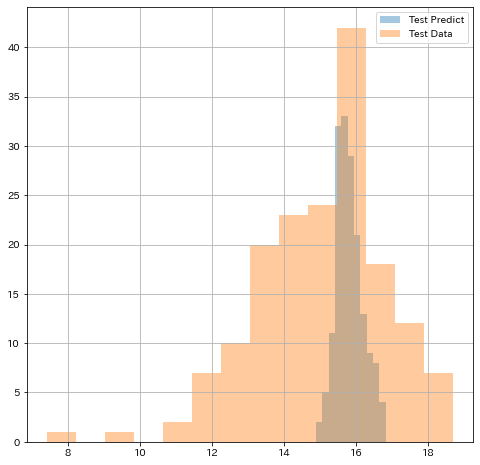

In [57]:
test_y=np.log1p(test['Total Gross'].values)

fig, ax = plt.subplots(figsize=(8, 8))

#変数を対数スケールで学習させなかった場合
sns.distplot(pred, label='Test Predict',kde=False)
sns.distplot(test_y, label='Test Data',kde=False)
#sns.distplot(oof, label='Out Of Fold')


#変数を対数スケールで学習させた場合
#sns.distplot(np.log1p(pred), label='Test Predict',kde=False)
#sns.distplot(np.log1p(test_y), label='Test Data',kde=False)
#sns.distplot(oof, label='Out Of Fold')

ax.legend()
ax.grid()
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


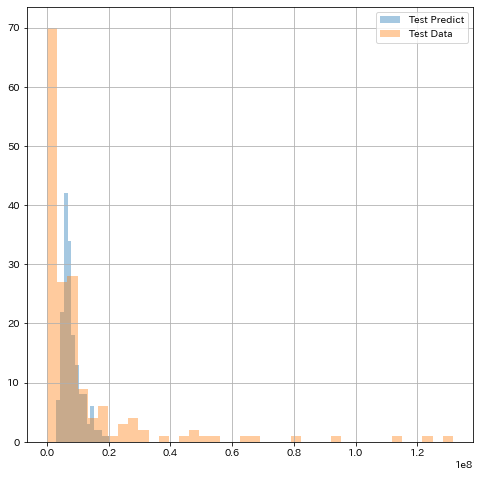

In [58]:
test_y=test['Total Gross'].values

fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(np.expm1(pred), label='Test Predict', kde=False)
sns.distplot(test_y, label='Test Data', kde=False)
#sns.distplot(oof, label='Out Of Fold')

ax.legend()
ax.grid()
plt.show()

In [59]:
import matplotlib.pyplot as plt 
%matplotlib inline 
def yyplot(y_obs, y_pred):
  yvalues = np.concatenate([y_obs.flatten(), y_pred.flatten()])
  ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
  fig = plt.figure(figsize=(6,6))
  plt.scatter(y_obs, y_pred)
  plt.plot([ymin - yrange*0.01, ymax + yrange*0.01],[ymin - yrange * 0.01, ymax + yrange * 0.01])
  plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
  plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
  plt.xlabel('y_obserbed', fontsize=24)
  plt.ylabel('y_predicted', fontsize=24)
  plt.title('yyplot', fontsize=24)
  plt.tick_params(labelsize=16)
  plt.show() 

  return fig

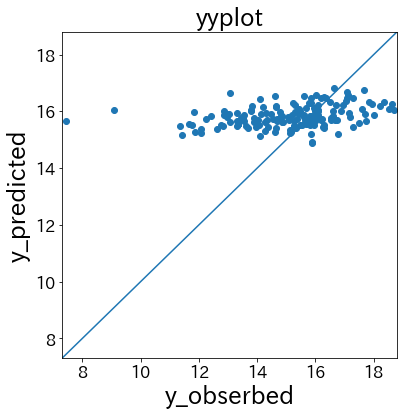

In [60]:
test_y=test['Total Gross'].values

fig = yyplot(np.log1p(test_y), pred)

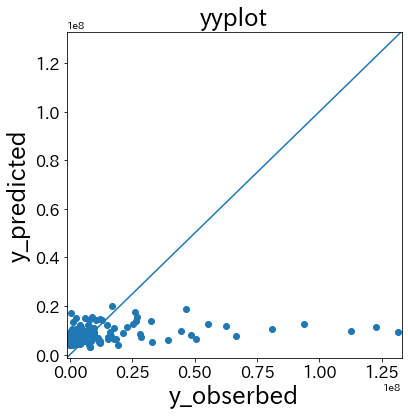

In [61]:
fig = yyplot(test_y, np.expm1(pred))

In [62]:
#決定係数
#r2_score(y_true, y_pred)
print(r2_score(test_y, np.expm1(pred)))

0.038342031333048254


In [63]:
t_y=np.log1p(test_y)
p_y=pred
#print(len(t_y),len(p_y))
print(r2_score(t_y, p_y))

-0.07999937579587413


In [64]:
def show_evals_result(evals_result:dict, fold:int):

    seed = eval_result['seed']
    fold = eval_result['fold']

    #rmse
    eval_metric_rmse = evals_result['valid']['rmse']
    train_metric_rmse = evals_result['train']['rmse']

    # グラフにプロットする
    _, ax1 = plt.subplots(figsize=(8, 8))
    ax1.plot(eval_metric_rmse, label='valid logloss', c='y')
    ax1.plot(train_metric_rmse, label='train logloss', c='b')
    ax1.set_ylabel('root mean square error')
    ax1.set_xlabel('rounds')
    ax1.set_title(f'Result of seed {seed}-fold {fold} ')
    ax1.legend()

    plt.grid()
    plt.show()

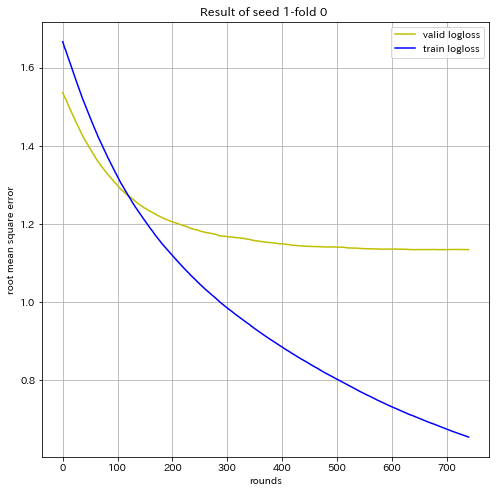

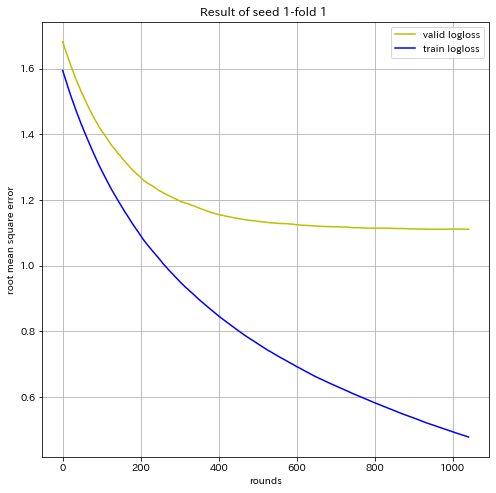

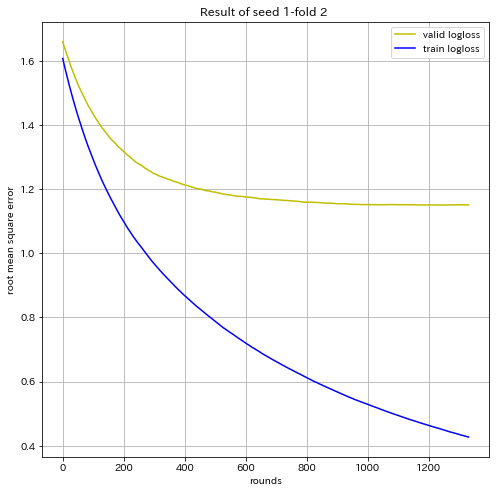

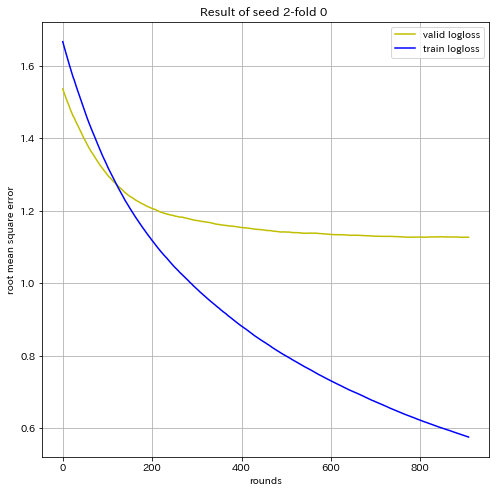

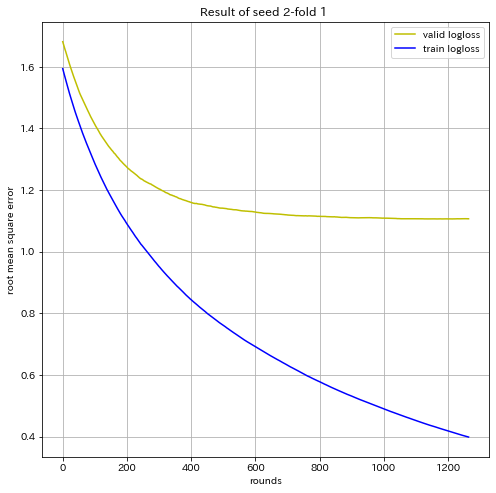

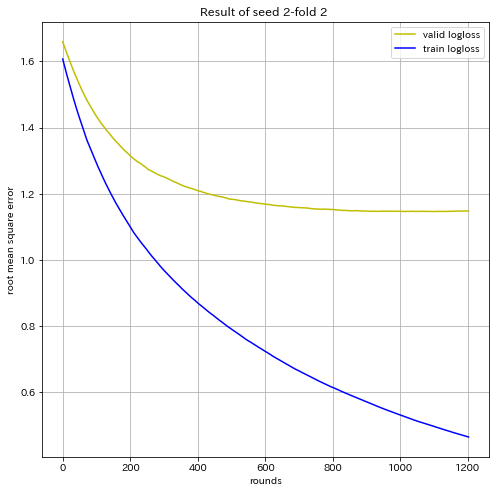

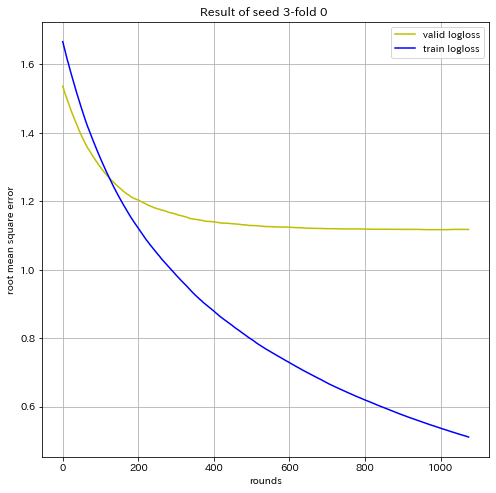

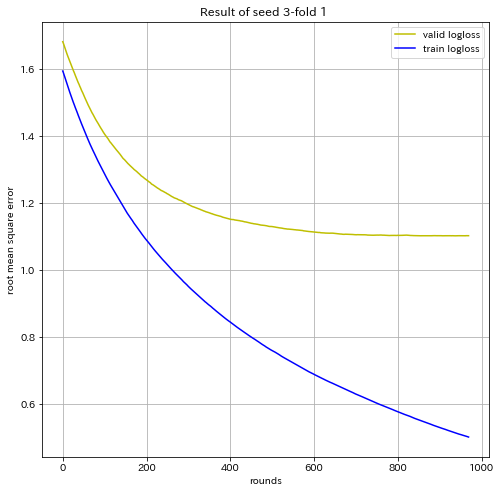

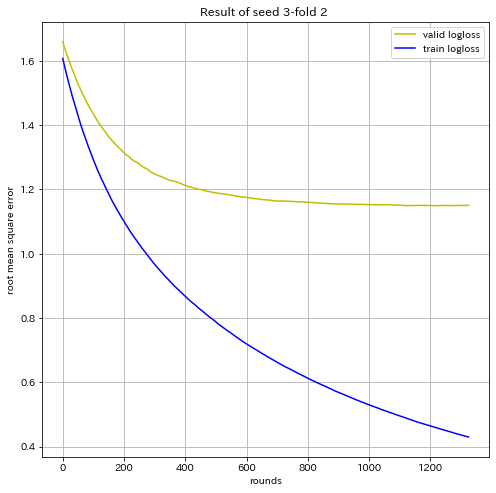

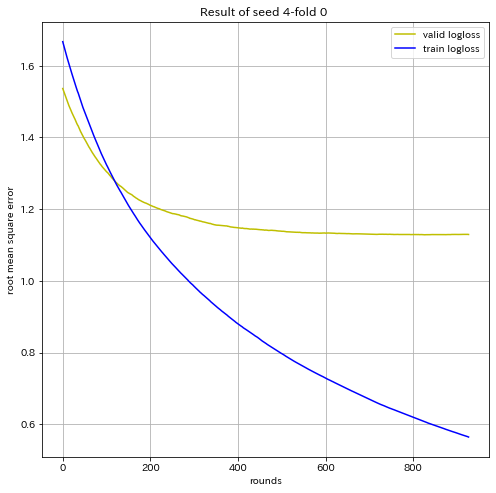

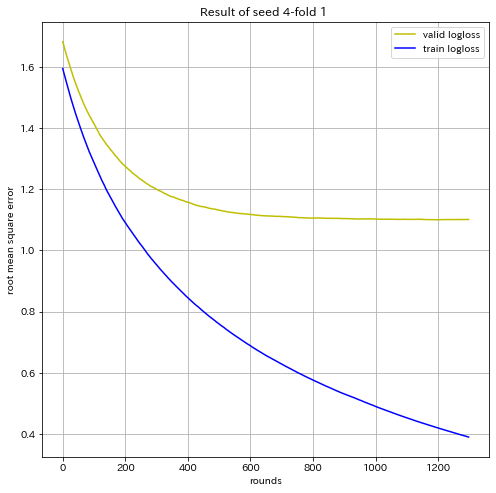

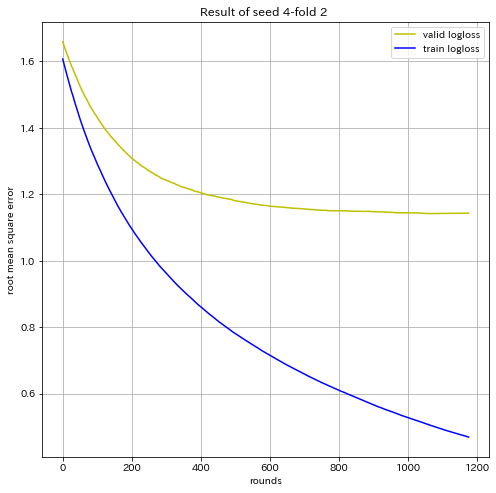

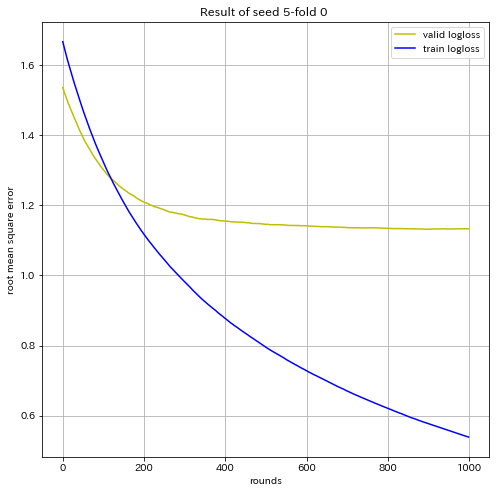

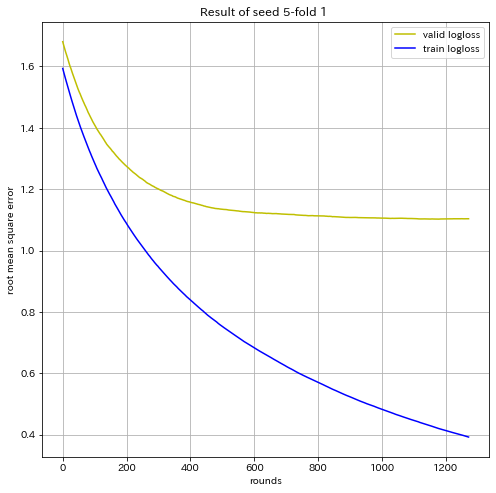

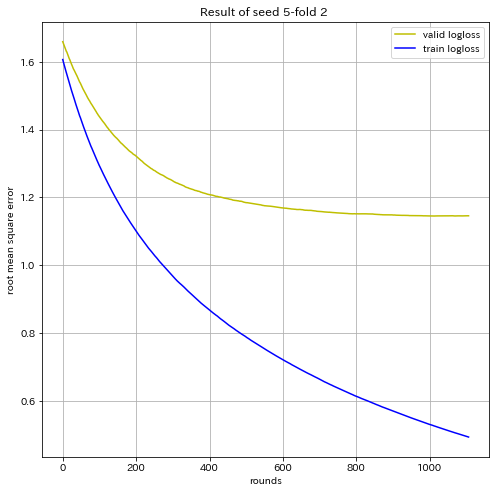

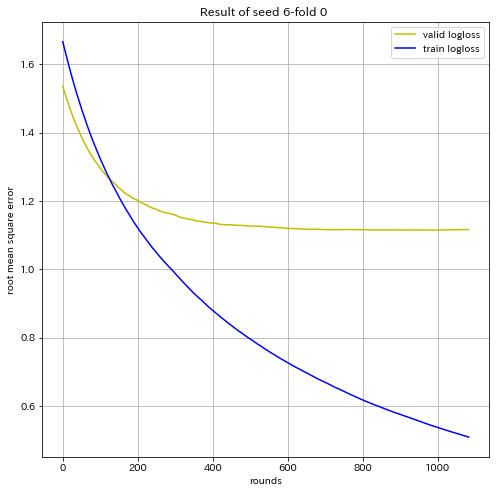

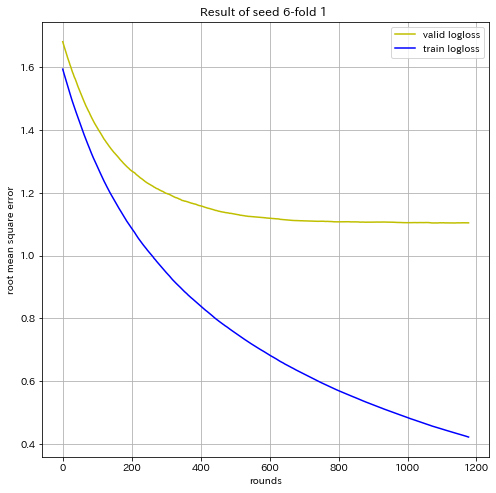

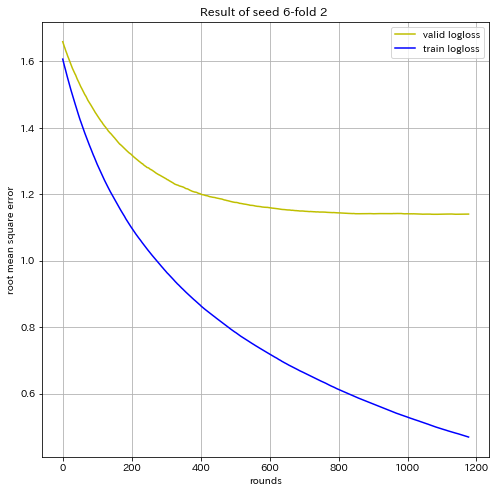

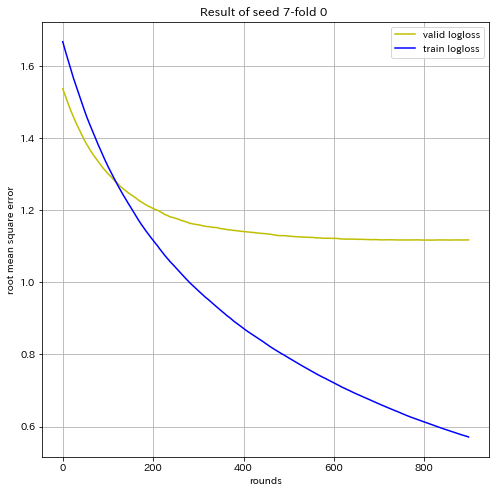

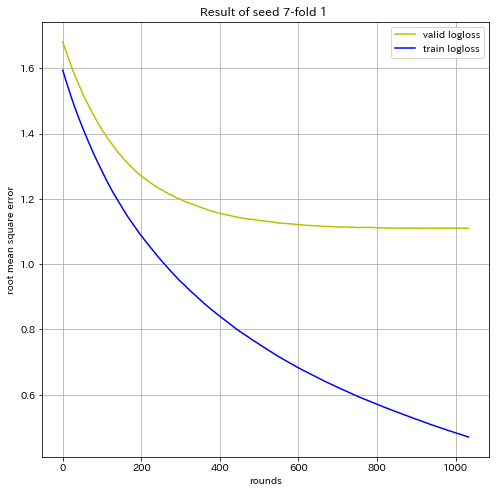

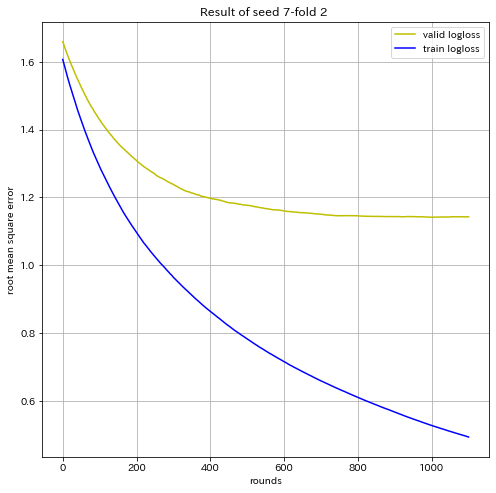

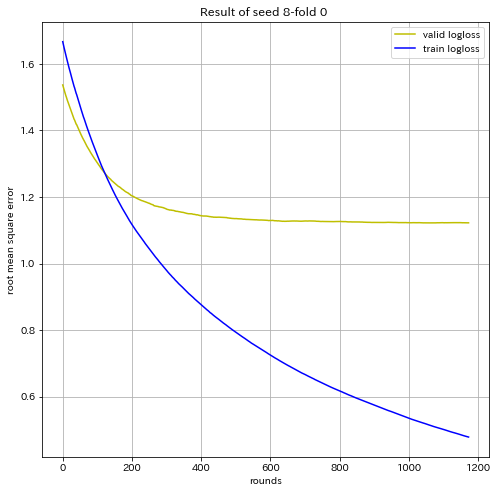

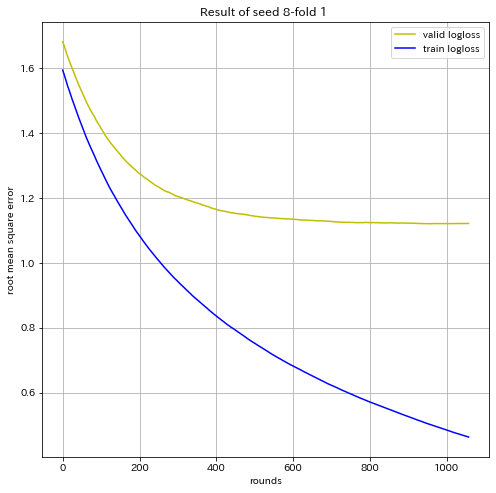

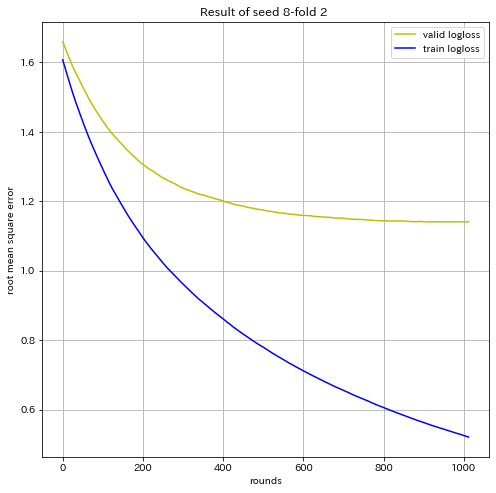

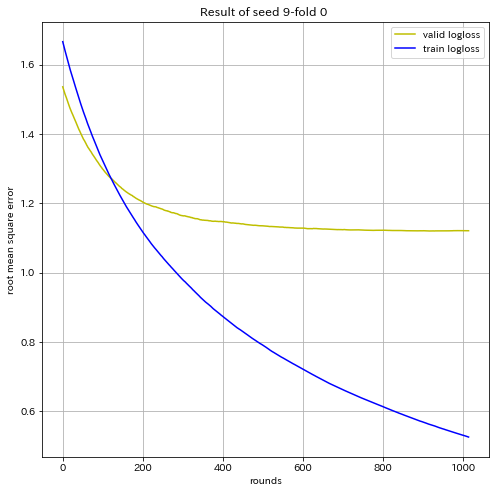

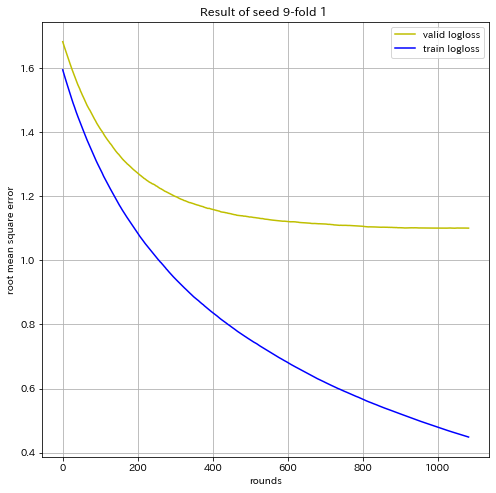

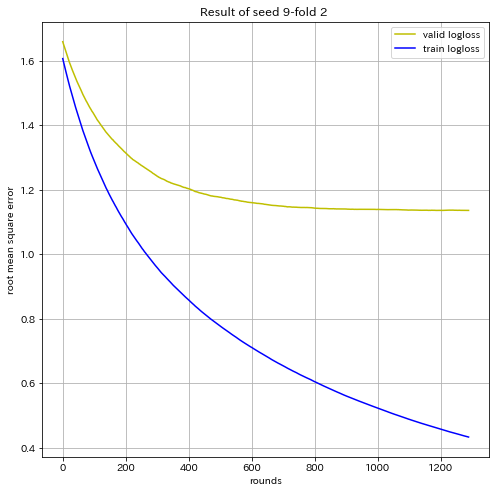

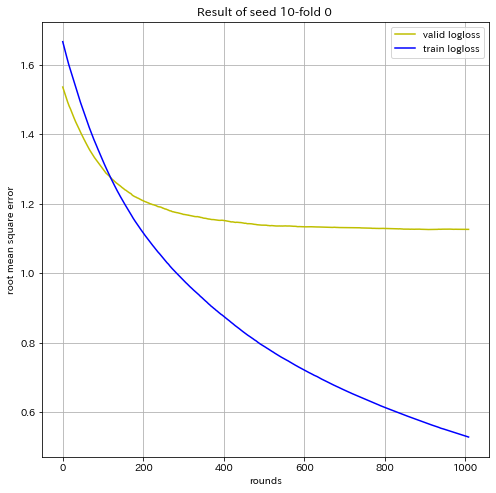

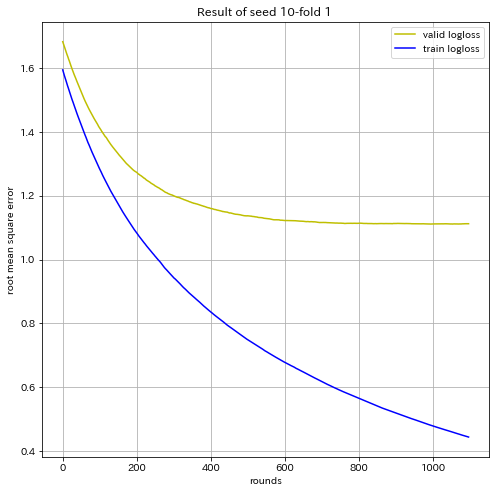

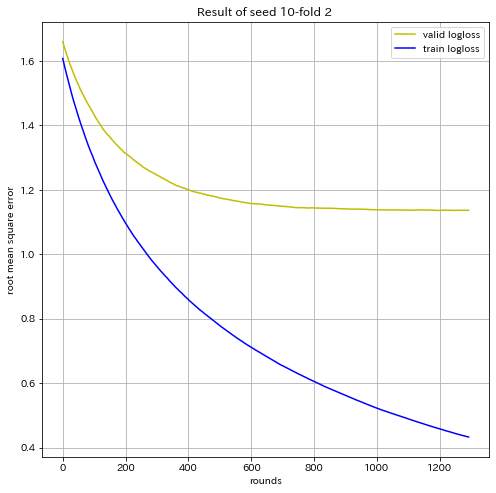

In [65]:
for i, eval_result in enumerate(eval_results):
  show_evals_result(eval_result, i)

In [66]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance('gain')
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

   
    #feature_importance_df = feature_importance_df[feature_importance_df['feature_importance']>0]
    #sns.boxenplot(data=feature_importance_df, y='column', x='feature_importance',  ax=ax, palette='ocean')
    #fig, ax = plt.subplots(figsize=(15, 20))

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(20, 20))
    sns.boxenplot(data=feature_importance_df, y='column', x='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90, labelsize=10)
    ax.tick_params(axis='y', labelsize=15)
    ax.grid()
    fig.tight_layout()
    return fig, ax, feature_importance_df

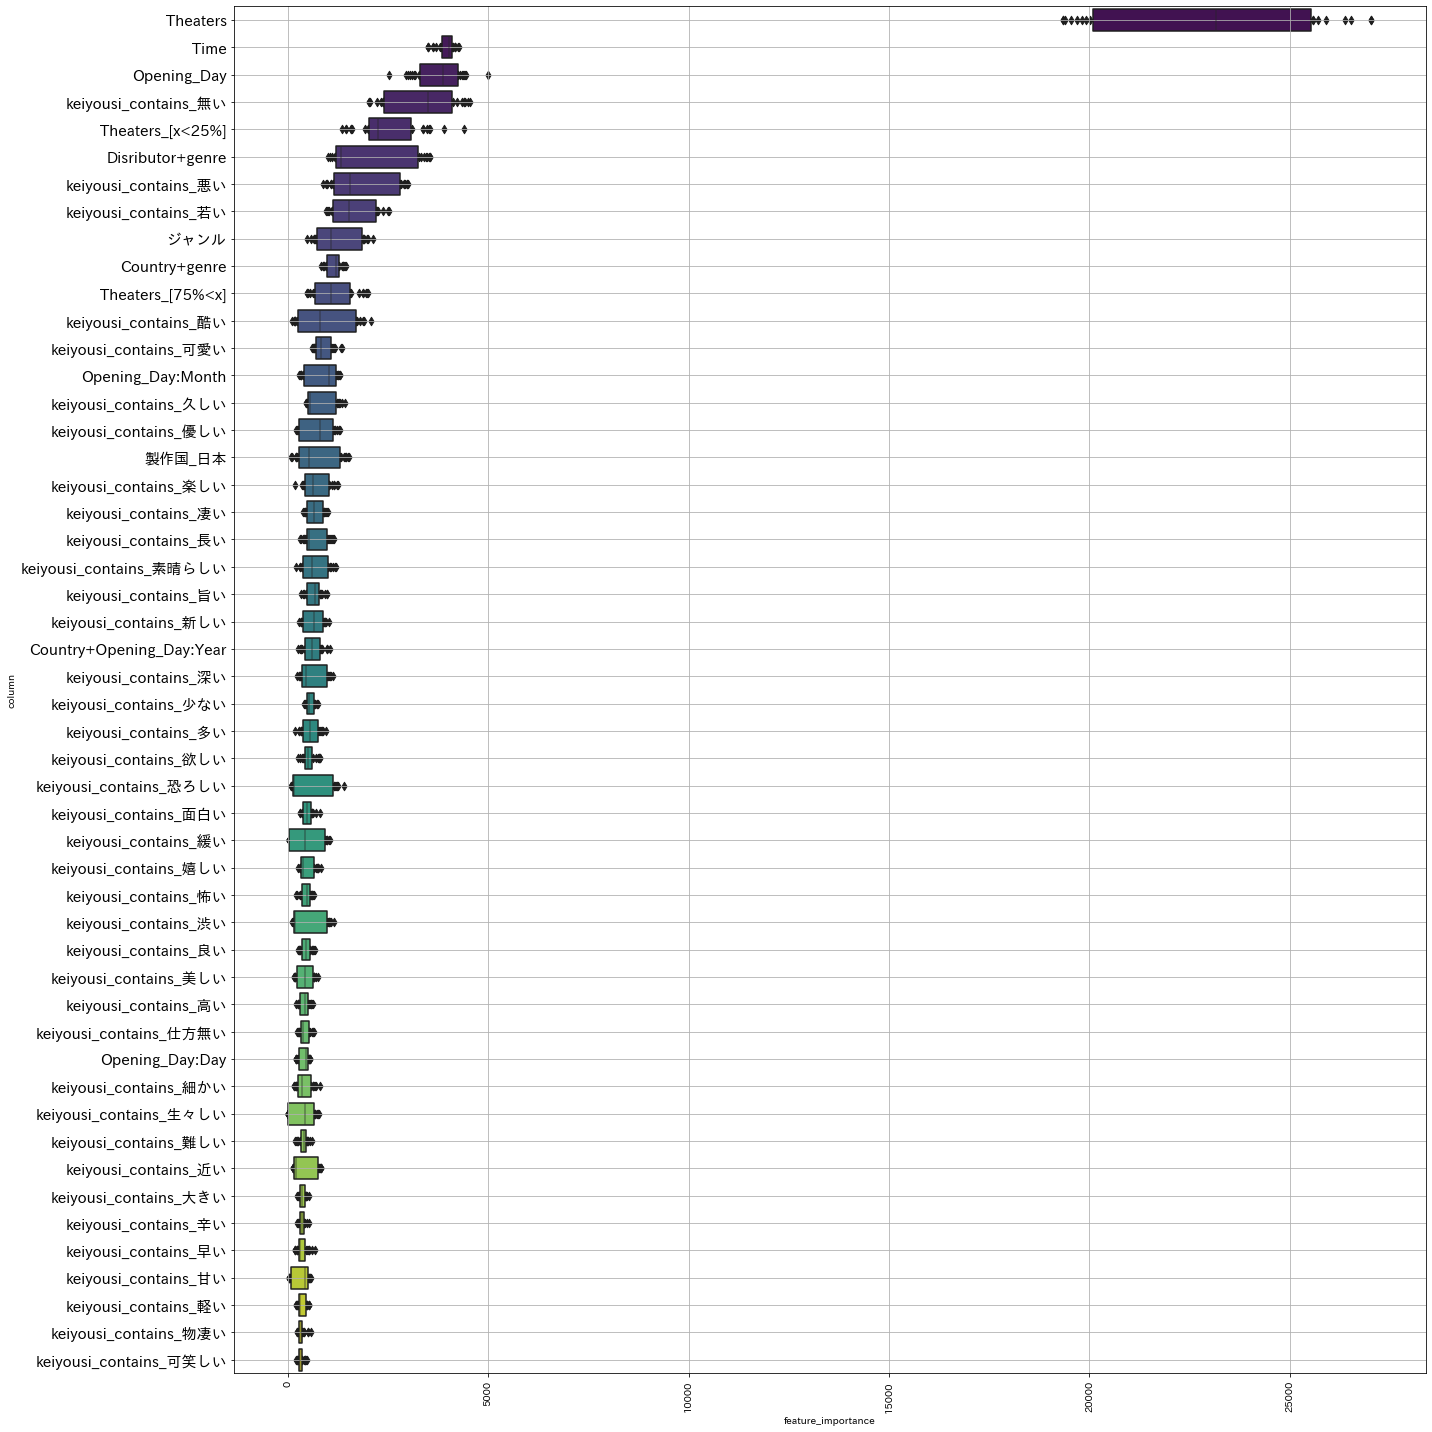

In [67]:
fig, ax, feature_importance_df = visualize_importance(models, train_features.drop([target_col, 'kfold'], axis=1))

In [68]:
pd.set_option('display.max_columns', 200)

feature_importance_df.groupby('column').sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False)[0:50]

,feature_importance
column,
Theaters,690437.547264
Time,118643.369272
Opening_Day,113441.013584
keiyousi_contains_無い,100479.049477
Theaters_[x<25%],74533.503264
Disributor+genre,58627.066379
keiyousi_contains_悪い,54758.827240
keiyousi_contains_若い,48970.924246
ジャンル,36861.547631


#ジャンルが重要視されていることが分かった．ジャンルに関する特徴量を作ると良いかもしれない．<br>
ジャンルに関するaggregrationなど

In [ ]:
"""# 決定木を可視化
def display_tree(clf):
    ax = lgb.plot_tree(clf, tree_index=0, figsize=(10, 10), show_info=['split_gain'])
    plt.show()
    print('lightGBM　木の可視化')
    graph = lgb.create_tree_digraph(clf, tree_index=0, format='png', name='Tree')
    graph.render(view=True)

for i in models:
  display_tree(i)
  
"""

In [ ]:
#カラムに,が入るとエラーが出る
train[train.columns[3178]]

#追加データとして使えそう？？ 

https://gem-standard.com/news_releases/244